In [31]:
import numpy as np
import scipy as sc
import cupy as cp
import matplotlib.pyplot as plt
import quantecon as qe
import time
from scipy.optimize import minimize_scalar
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits import mplot3d

In [2]:
print(cp.cuda.runtime.getDeviceCount())

1


In [3]:
print(cp.cuda.Device(0))

<CUDA Device 0>


Parameters

In [44]:
# P = [n_a, beta, theta, n_z, rho, sigma, mu, delta, gamma]
P = [31, 0.96, 3, 19, 0.95, 0.2, 0.1, 0.08, 1]

In [5]:
# P1 = [n_a, beta, theta, n_z, rho, sigma, mu, delta, gamma]
P1 = [101, 0.96, 3, 19, 0.95, 0.2, 0.1, 0.08, 2]

In [6]:
# P1 = [n_a, beta, theta, n_z, rho, sigma, mu, delta, gamma]
P2 = [101, 0.96, 3, 19, 0.95, 0.2, 0.1, 0.08, 10]


Expanding grid

In [7]:
def expanding_grid(params):

    zero_grid = np.linspace(0,1,params[0]).reshape(-1,1)

    asset_grid = np.zeros(shape=(params[0],1))

    a_low = 0

    a_high = 2000

    for i in range(P[0]):
        asset_grid[i] = (a_low) + (a_high - a_low) * (zero_grid[i] ** P[2])

    return asset_grid

Utility

In [8]:
def u(c, params):
    if params[-1] == 1:
        return np.log(c)
    else:
        return ((c**(1-params[-1]))/(1-params[-1]))

Markov chain

In [9]:
def Markov_chain(params):

    n_z, rho, sigma, mu =  params[3], params[4], params[5], params[6]
    
  # mc = qe.markov.approximation.rouwenhorst(n_z, rho, sigma, mu)
    mc = qe.markov.approximation.rouwenhorst(n_z, rho, sigma, mu)
    
    z_grid, T = mc.state_values, mc.P

    return z_grid, T

Create a function which will find the first element of an array for which the predicate is true

In [10]:
def findfirst(array, cutoff):
    for i, value in enumerate(array):
        if value > cutoff:
            return i
            break
    return None

Check, with an example, that the findfirst function is working correctly

In [11]:
random = np.random.rand(1,10)
sorted = np.sort(random, axis=None)
print(sorted)
print(findfirst(sorted, 0.9))

[0.01254482 0.0182356  0.0492461  0.07663793 0.34945232 0.43536449
 0.61941585 0.68410285 0.79232563 0.97105277]
9


Next, create the function to calculate the invariant distribution.

In [12]:
def Invariant_Distribution(params, policy, transition, grid):
    
   # M(i, j, k, l) -> current state: (i,j), next state: (k,l)
    M = np.zeros(shape=(params[0], params[3], params[0], params[3]))
   # for i in range(n_a):
    for i in range(params[0]):
       # for j in range(n_z):
        for j in range(params[3]):
           # if G1[i,j]<=np.squeeze(grid[1]):
            if policy[i,j]<=np.min(grid):
               # if you stay at the borrowing constraint across periods, your transition is only affected by evolution of AR1 process. 
                M[i,j,0,:] = transition[j,:]

            elif policy[i,j]>=np.max(grid):
               # if you stay at the max asset holdings across periods, your transition is only affected by evolution of AR1 process.
                M[i,j,params[0]-1,:] = transition[j,:]

            else:
                
              # Some explanation is required for this step.
              # The "findfirst" function is defined above. There, we ask Python to look at the row vector, and return 
              # the index of the first element where the predicate is true.
                
                index = findfirst(grid, policy[i,j])
                
              # Individuals have chosen policy[i,j] from a continuous choice set.
              # However, policy[i,j] may not necessarily lie on our asset grid. We need to move them to a grid point.
              # We linearly intepolate a probability based on the position of policy[i,j] with regard to the grid points closest.
              # Individuals are more likely to transition to whichever grid point is closer.
                
                prob = (grid[index] - policy[i,j])/(grid[index] - grid[index-1])
                
                M[i,j,index-1,:] = transition[j,:]*prob
                
                M[i,j,index,:] = transition[j,:]*(1-prob)

    O = M.reshape((params[0] * params[3], params[0] * params[3]))

   #### Matteo's implementation in Julia. ####
    
   # O = np.zeros(shape=(params[0] * params[3], params[0] * params[3]))
                 
   # l=0
    
   # for i in range(params[0]):
        
       # for j in range(params[3]):
            
          #  O[:,j+l*params[3]]  = M[:,:,i,j].T.flatten()

      #  l=l+1
    
   #### Matteo's implementation in Julia. ####
    
    # Make sure that O is a Markov chain
    for i in range(params[0]*params[3]):

        O[i, :] = (O[i, :]) / (np.sum(O[i, :]))

    number_of_states = (params[0]*params[3])

    #print("O", len(O), len(O.T))
    
    # What are we doing here?
    # We need to solve the system which calculates the invariant distribution, pi*P = pi. We also
    # need the extra condition that elements of pi must some to 1 such that we have an invariant prob dist. Therefore, the code below
    # solve this modified system of linear equations. Note that we have 0 = pi * (I - P.T)
    X = np.vstack([(np.eye(number_of_states) - O.T), np.ones(number_of_states)])

    #print("X", len(X), len(X.T))

    Y = np.reshape(np.concatenate((np.zeros(number_of_states), np.ones(1))), (number_of_states+1,1))

    #print("Y", len(Y), len(Y.T))

    #Invariant = np.linalg.lstsq(X, np.concatenate((np.zeros(number_of_states), np.ones(1))), rcond=None)[0]

    Invariant = np.linalg.lstsq(X, Y, rcond=None)[0]

    #print("Invariant", len(Invariant), len(Invariant.T))

    Pi = Invariant.reshape((params[0] * params[3],1))

    #print("Pi", len(Pi), len(Pi.T))
    
    Pi[Pi < 0] = 0

    Pi = Pi / np.sum(Pi)

    return Pi

Change iterate function slightly to work with Aiyagari equilibrium function

In [52]:
def iterate_howard_Aiyagari(params, r, w, b, toler, max_iter, how_iter, Z, T, A, V0):

    iter = 0
    
    iter_error = toler + 1
    
    #V0 = np.zeros(shape=(params[0], params[3]))
    
    #G0 = np.zeros(shape=(params[0], params[3]))
    
    V1 = np.ones(shape=(params[0], params[3]))

    start_time = time.time()
                      
    bound = w * np.exp(np.min(Z))/r

    new_bound = np.append(bound, b)

    if b > 0 :
            
        phi = np.min(new_bound)

    else:

        phi = b

    while iter <= max_iter:

        V_out, G = B_Aiyagari(V0, params, r, w, T, A, Z, phi) 

        #V_copy = V_out.copy()

        for _ in range(how_iter):
            
            for j in range(params[3]):

                Expected_value = np.dot(V_out, T[j,:])

                Interp_Ev = sc.interpolate.interp1d(np.squeeze(A), np.squeeze(Expected_value), kind='cubic', fill_value='extrapolate')

                for i in range(params[0]):

                    objective = lambda a: (u( w * np.exp(Z[j]) + ((1+r) * A[i]) - (r * phi) - a, params) + (params[1] * Interp_Ev(a)))

                    V1[i,j] = objective(G[i,j])

            V_out = V1.copy()
    
        #iter_error = np.max((np.abs(V_out-V_copy)))

        #if iter % 1 == 0:
            #print(f"Iteration {iter}, Error: {iter_error}")
        
        #if iter_error < toler:
            #print(f"Converged in {iter} iterations, Error: {iter_error}")
            #break

        #c_low = np.min(V_out-V_copy)
        c_low = np.min(V_out-V0)

        #c_high = np.max(V_out-V_copy)
        c_high = np.max(V_out-V0)

        iter_error = np.max((np.abs(V_out-V0)))

        #if iter == 0:
            #print(f"Iteration {iter}, Error: {iter_error}")

        if iter % 10 == 0:
            print(f"Iteration {iter}, Error: {iter_error}")

        iter += 1

        if iter_error < toler:
            print(f"Converged in {iter} iterations, Error: {iter_error}")
            break

        V0 = V_out + (c_low + c_high) / 2

    V1, G1 = B_Aiyagari(V0, params, r, w, T, A, Z, phi)

    end_time = time.time()

    execution_time = end_time - start_time

    print(f"Execution time = {execution_time} seconds")

    return V1, G1

Change Bellman equation slightly to work with Aiyagari equilibrium function

In [14]:
def B_Aiyagari(V0, params, r, w, T, A, Z, phi):

    V = np.zeros(shape=(params[0], params[3]))

    G = np.zeros(shape=(params[0], params[3]))

    for j in range(params[3]):

        Expected_value = np.dot(V0, T[j,:])

        Interp_Ev = sc.interpolate.interp1d(np.squeeze(A), np.squeeze(Expected_value), kind='cubic', fill_value='extrapolate')

        for i in range(params[0]):

                # Here, I have two methods for calculating the value and policy functions.
                # One method, "objective", uses a lambda function
                # The other uses "optimiser" (defined below)

                objective = lambda a: - (u( w * np.exp(Z[j]) + ((1+r) * A[i]) - (r * phi) - a, params) + (params[1] * Interp_Ev(a)))

                # def optimiser(a, params, A, Z, phi, w, Interp_Ev):
                #   return - (u( w * np.exp(Z[j]) + ((1+r) * A[i]) - (r * phi) - a, params) + (params[1] * Interp_Ev(a)))

                lb = 0

                ub = (w * np.exp(Z[j])) + ((1+r) * A[i])

                # For "objective", we don't need to pass any args into the minimisation since it is taking in the lambda function             
                result = minimize_scalar(objective, bounds = (lb, ub), method = 'bounded')
            
                # On the other hand, when using "optimiser", we do need to pass args into the mimimisation. 
                # result = minimize_scalar(optimiser, bounds = (lb, ub), args = (params, A, Z, phi, w, Interp_Ev), method = 'bounded')
            
                argmax = result.x

                value = -result.fun

                # The final thing we need to do is set the min based on whether we are using "obj" or "opt"

                min = np.float64(objective(0))

                # min = optimiser(lb, params, A, Z, phi, w, Interp_Ev)

                if value < min:

                    G[i,j] = lb

                    V[i,j] = min
            
                else:

                    G[i,j] = argmax

                    V[i,j] = value                    

    return V, G    

Change Aiyagari function

In [89]:
def Aiyagari_equilibrium_test(r, params, tfp, alpha, toler, tolerV, max_iter, b, how_iter):

    start_time = time.time()

    z_grid, T = Markov_chain(params)

    asset_grid = expanding_grid(params)
    
    error = toler + 1

    # We need an initial distribution 
    initial_dist = np.zeros(shape=(params[0] * params[3], 1))

    # We also need to calculate the invariant distribution of the labour income process
    Invariant_Labour_Process = np.vstack([(np.eye(params[3]) - T.T), np.ones(params[3])])
    
    ones = np.ones(1)
    
    sol = np.concatenate((np.zeros(19), ones)).reshape(-1,1)
    
    mu = np.linalg.lstsq(Invariant_Labour_Process, sol, rcond=None)[0]
    
    L = np.zeros(19).reshape(-1,1)

    L = np.dot(mu.T, z_grid.reshape(-1,1))

    r_steady_state = (1/params[1]) - 1

    #print(f"r_steady_state = {r_steady_state}")

    #V = np.zeros(shape=(params[0], params[3]))
    #G = np.zeros(shape=(params[0], params[3]))

    V0 = np.zeros(shape=(params[0], params[3]))
    #G0 = np.zeros(shape=(params[0], params[3]))

    p0 = np.zeros(shape=(params[0] * params[3], 1))
    
    rnew = r_steady_state

    Ks, Kd = 1, 1

    w = 1

    phi = 0

    price_iter = 0

    while error > toler and price_iter <= (max_iter):

        print(f"Price iteration = {price_iter}")

        r_init  = (r + rnew) / 2

        print(f"r_init = {r_init}")

        Kd = (( (tfp * alpha * L ** ( 1 - alpha)) / (r_init + params[-2]) ) ** ( 1 / ( 1 - alpha ) ))

        w = (tfp * ( 1 - alpha ) * ( (Kd/L) ** alpha ))

        print(f"w = {w}")

        bound = w * np.exp(np.min(z_grid))/r_init

        ### bound = 110.47845943 ###

        new_bound = np.append(bound, b)

        if b > 0 :
            
            phi = np.min(new_bound)

        else:

            phi = b

        V, G = iterate_howard_Aiyagari(params, r_init, w, b, tolerV, max_iter, how_iter, z_grid, T, asset_grid, V0)

        print(f"Converged for r = {r_init}, w = {w}")
        
        p0 = Invariant_Distribution(params, G, T, asset_grid)

        #print("p0", len(p0), len(p0.T))
   
        pol = np.reshape(G - phi, (params[0] * params[3], 1))

        #print("pol", len(pol), len(pol.T))

        Ks = np.dot(p0.T, pol)

        #print(Ks)

        diff = Ks - Kd

        if diff > 0:

            rnew = r_init

        else: 
            
            r = r_init

        error = np.abs(diff)

        print(f"Error: {error}") 

        V0 = V.copy()

        if price_iter % 10 == 0:
             print(f"Price iteration {price_iter}, Error: {error}, Prices: {r, rnew}, Quantities: {Ks, Kd}")

        price_iter += 1
        
        if error < toler:
            print(f"Converged in {price_iter + 1} price iterations")
            r_final = r_init
            w_final = w
            print(f"r = {r_final}, w = {w_final}")
            break

        if price_iter == max_iter:
            print(f"failed to converge in {max_iter} iterations")
            break
            
    end_time = time.time()

    Overall_time = end_time - start_time

    ### wealth ###

    wealth = np.zeros(shape=(params[0], params[3]))
    
    for j in range(params[3]):
        for i in range(params[0]):
            wealth[i,j] = w_final*np.exp(z_grid[j]) + (1+r_final)*asset_grid[i] - phi*r_final


    ### compute gini coefficient ###

    #gini_grid = np.zeros(shape=(params[0] * params[3], 1))

    #for i in range(params[0] * params[3]):
        
        #gini_grid[i] = np.sum(np.abs(wealth[i] - wealth))

    #gini = (np.sum(gini_grid) / (2*np.mean(wealth)*((params[0] * params[3])^2)))
    
    #print(f"gini coefficient = {gini}")

    ### plot value and policy functions at equilibrium ###

    fig, ax = plt.subplots(figsize=(10, 6))
    for j in range(params[3]):
        ax.plot(asset_grid, V[:, j], label=f'Labour Shock {j+1}')

    ax.set_title('Value Function')
    ax.set_xlabel('Assets')
    ax.set_ylabel('Value')
    ax.legend()
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 6))
    for j in range(params[3]):
        ax.plot(asset_grid, G[:, j], label=f'Labour Shock {j+1}')

    ax.set_title('Policy Function')
    ax.set_xlabel('Assets')
    ax.set_ylabel('Optimal Assets choice')
    ax.legend()
    plt.show()

    ### invariant distribution plot ###

    p0 = np.reshape(p0, (params[0], params[3])) 

    fig = plt.figure(figsize=(16, 10))
    ax = plt.axes(projection = '3d')
    ax.set_xlim([0, 2000])
    ymin = np.min(np.exp(z_grid))
    ymax = np.max(np.exp(z_grid))
    ax.set_ylim([ymin, ymax])
    ax.set_zlim([0, 0.12])
    # Creating color map
    my_cmap = plt.get_cmap('hot')
    ax.plot_surface(asset_grid, np.exp(z_grid), p0)
    surf = ax.plot_surface(asset_grid, np.exp(z_grid), p0, cmap=my_cmap, edgecolor = 'none')
    fig.colorbar(surf, ax = ax, shrink = 1, aspect = 5)
    ax.set_title('Invariant Distribution')
    ax.set_xlabel('Assets')
    ax.set_ylabel('Shocks')
    ax.set_zlabel('Mass')
    plt.show()

    end_time = time.time()

    Overall_time = end_time - start_time
    
    print(f"overall time: {Overall_time} seconds")

    return Ks, Kd, r, w, V, G, p0, wealth
    

In [90]:
Ks, Kd, r, w, V, G, p0, wealth = Aiyagari_equilibrium_test(0.00, P, 2.5, 0.33, toler=1e-6, tolerV=1e-8, max_iter=10000, b=10.0, how_iter=25)
### For CRRA utility ###
## Work in progress ##

# Ks, Kd, r, w, V, G, p0 = Aiyagari_equilibrium_test(0.00, P, 2.5, 0.33, toler=1e-6, tolerV=1e-8, max_iter=10000, b=3.0, how_iter=25)
# Make sure to go back and change gamma and the grid

C:\Users\bayle\AppData\Local\Temp\ipykernel_33288\598050104.py:6: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = qe.markov.approximation.rouwenhorst(n_z, rho, sigma, mu)
C:\Users\bayle\AppData\Local\Temp\ipykernel_33288\2824741865.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  min = np.float64(objective(0))
C:\Users\bayle\AppData\Local\Temp\ipykernel_33288\2824741865.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  G[i,j] = argmax
C:\Users\bayle\AppData\L

Price iteration = 0
r_init = 0.02083333333333337
w = [[4.71658224]]


C:\Users\bayle\AppData\Local\Temp\ipykernel_33288\3992704634.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  V1[i,j] = objective(G[i,j])


Iteration 0, Error: 87.68575501850161
Iteration 10, Error: 0.001282491598146862
Iteration 20, Error: 9.930772648658603e-09
Converged in 21 iterations, Error: 9.930772648658603e-09
Execution time = 32.312331676483154 seconds
Converged for r = 0.02083333333333337, w = [[4.71658224]]
Error: [[37.26395759]]
Price iteration 0, Error: [[37.26395759]], Prices: (0.0, 0.02083333333333337), Quantities: (array([[83.34183022]]), array([[46.07787263]]))
Price iteration = 1
r_init = 0.010416666666666685
w = [[4.97681878]]
Iteration 0, Error: 2.342601512811129
Iteration 10, Error: 6.710089280659304e-06
Converged in 17 iterations, Error: 5.771966016254737e-09
Execution time = 22.48715305328369 seconds
Converged for r = 0.010416666666666685, w = [[4.97681878]]
Error: [[23.29058116]]
Price iteration = 2
r_init = 0.015625000000000028
w = [[4.84141001]]
Iteration 0, Error: 1.061401082741952
Iteration 10, Error: 2.1022118801283796e-06
Converged in 16 iterations, Error: 5.828482585457095e-09
Execution time 

KeyboardInterrupt: 

In [248]:
def gini_function(wealth, dist, params):
    
    number_of_states = params[0] * params[3]

    reshaped_wealth = np.reshape(wealth, (number_of_states,1))

    dist = np.reshape(dist, (number_of_states,1)) 

    sorted_wealth = np.sort(reshaped_wealth, axis=0)

    index = np.argsort(reshaped_wealth, axis=0)

    dist=dist[index]

    Wlevels = np.zeros(shape=(params[0] * params[3], 1))

    Dist = np.zeros(shape=(params[0] * params[3], 1))

    Lorenz = np.zeros(shape=(number_of_states,1))

    New_Lorenz = np.zeros(shape=(number_of_states,1))

    for i in range(number_of_states):
        
        Wlevels[i] = sorted_wealth[i] * dist[i]

    for i in range(number_of_states):

        if i == 0:

            Lorenz[i] = Wlevels[i]

            Dist[i] = dist[i]

        else:

            Lorenz[i] = Lorenz[i-1] + Wlevels[i]
            
            Dist[i] = Dist[i-1] + dist[i]

    #print(Dist) ## Working correctly

    max = np.max(Lorenz)

    for i in range(number_of_states):

        New_Lorenz[i] = Lorenz[i] / max

    #print(New_Lorenz)

    B = sc.integrate.trapezoid(New_Lorenz, x=Dist, axis=0)

    Gini = 1-2*B

    Gini_round = np.round(Gini, decimals=4)

    print(Gini_round)

    fig = plt.plot(Dist, New_Lorenz, label = "Share of accumulated wealth")
    fig = plt.plot(Dist, Dist, color='green', linestyle='dashed', label = "45o line")
    plt.title(f"Lorenz curve, Gini = {Gini_round}")
    plt.legend()
    plt.show()
    

    return Gini_round

[0.5951]


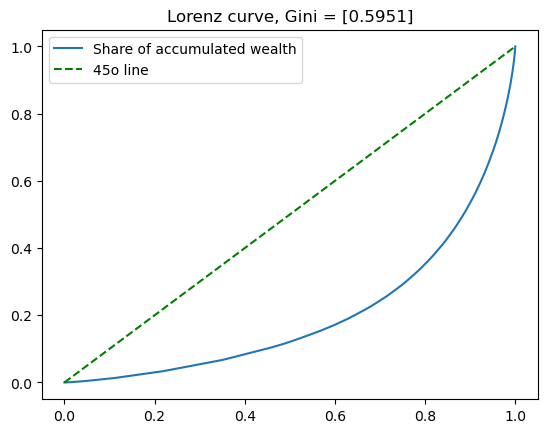

In [249]:
gini = gini_function(wealth, p0, P)